<a href="https://colab.research.google.com/github/skywalker0803r/works/blob/master/C5NP_250%E7%AD%86%E5%BB%BA%E6%A8%A1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')
import warnings 
warnings.simplefilter('ignore')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Load

In [2]:
import pandas as pd

data = pd.read_csv('/content/drive/My Drive/台塑輕油案子/data/test_250.csv',index_col=0).reset_index(drop=True)
mod  = data.index % 5
train = data.loc[ mod != 0 ,:]
test = data.loc[ mod == 0 ,:]
print(train.shape)
print(test.shape)

(200, 27)
(50, 27)


# def features & y_name

In [3]:
features = ['T10','T50','T90','N+A']
y_name = 'C5NP'
train = train[features+[y_name]]
test = test[features+[y_name]]
print(train.shape)
print(test.shape)

(200, 5)
(50, 5)


# info

In [4]:
train.describe()

,T10,T50,T90,N+A,C5NP
count,200.000000,200.000000,200.000000,200.000000,200.000000
mean,83.952000,108.532500,143.425000,47.181365,4.447034
std,16.868257,10.414746,10.241981,8.552356,4.182515
min,55.300000,84.800000,122.300000,30.718870,0.002000
25%,65.175000,100.425000,137.875000,39.278638,1.238336
50%,91.700000,111.400000,142.200000,48.046689,2.043376
75%,97.200000,115.300000,147.075000,53.986965,8.771517
max,116.900000,131.700000,198.500000,63.114705,16.611529


In [5]:
train.corr()

,T10,T50,T90,N+A,C5NP
T10,1.000000,0.856767,0.102906,0.715846,-0.955820
T50,0.856767,1.000000,0.524417,0.468263,-0.817769
T90,0.102906,0.524417,1.000000,-0.136834,-0.070582
N+A,0.715846,0.468263,-0.136834,1.000000,-0.734279
C5NP,-0.955820,-0.817769,-0.070582,-0.734279,1.000000


# features selected

In [0]:
features = ['T10']

# kde

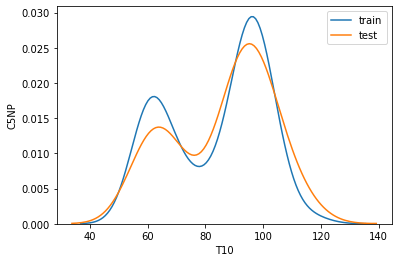

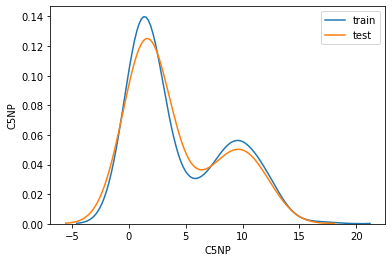

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

for col in features+[y_name]:
  sns.kdeplot(data = train[col],label='train')
  sns.kdeplot(data = test[col],label='test')
  plt.legend();plt.xlabel(col);plt.ylabel(y_name)
  plt.show()

# scatter

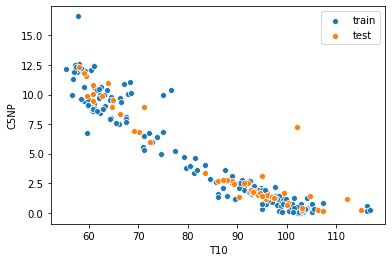

In [8]:
for x_col in features:
  sns.scatterplot(x=x_col,y=y_name,data=train,label='train')
  sns.scatterplot(x=x_col,y=y_name,data=test,label='test')
  plt.legend()
  plt.show()

# scaler

In [0]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(train[features])

train[features] = scaler.transform(train[features])
test[features] = scaler.transform(test[features])

# metric

In [0]:
from sklearn.metrics import r2_score,mean_squared_error,mean_absolute_error
from math import sqrt
def metric(y_t,y_p):
  res = {'R2':r2_score(y_t,y_p),
         'RMSE':sqrt(mean_squared_error(y_t,y_p)),
         'mean_absolute_error':mean_absolute_error(y_t,y_p)}
  return pd.DataFrame(res,index=[y_t.name])

In [0]:
def RMSE(y_t,y_p):
  return sqrt(mean_squared_error(y_t,y_p))

# modeling

In [32]:
import xgboost
from sklearn.svm import SVR
from sklearn.metrics.scorer import make_scorer
from math import sqrt
from lightgbm import LGBMRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LinearRegression
import warnings 
warnings.simplefilter('ignore')

#model = xgboost.XGBRegressor(objective='reg:squarederror')
model = SVR(C=2)
#model = LinearRegression()

#交叉驗證5次
val_scores = cross_validate(model,train[features],train[y_name],cv=5,
                            scoring = {'rmse': make_scorer(RMSE, greater_is_better=False)})

print('val_scores:',val_scores['test_rmse'])
print('val_scores.mean:',val_scores['test_rmse'].mean())

# fit 
model.fit(train[features],train[y_name])
# predict
test['y_pred'] = model.predict(test[features])

# metric
print('test_scores:')
metric(test[y_name],test['y_pred'])

val_scores: [-1.23702648 -1.90384108 -1.31826415 -0.86551571 -0.50529644]
val_scores.mean: -1.165988771496084
test_scores:


,R2,RMSE,mean_absolute_error
C5NP,0.913251,1.14899,0.542693


# line plot

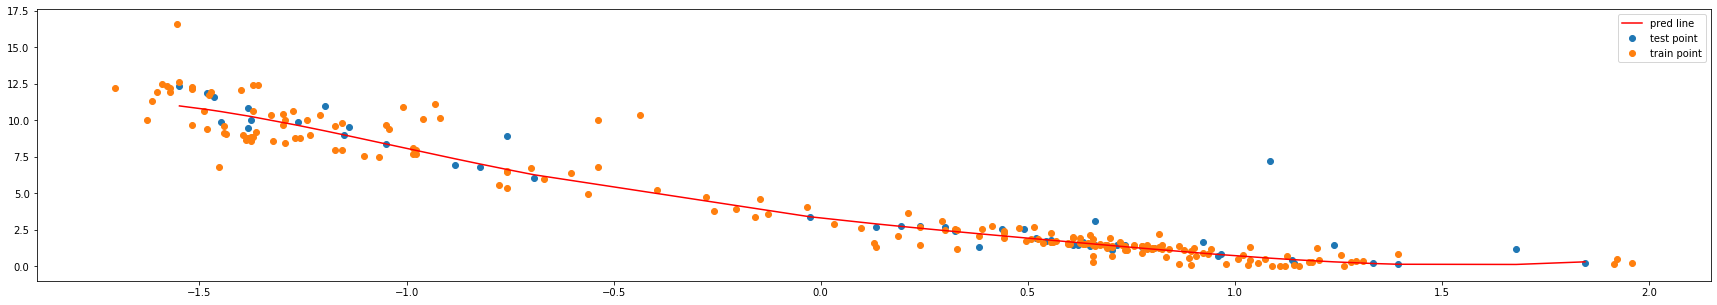

In [33]:
fig = plt.figure(figsize=(30,5))

#sorted point
test_point = test.sort_values(by='T10')
train_point = train.sort_values(by='T10')

#y_pred line
plt.plot(test_point['T10'],test_point['y_pred'],label='pred line',color='red')

#test point
plt.scatter(test_point['T10'],test_point[y_name],label='test point')

#train point
plt.scatter(train_point['T10'],train_point[y_name],label='train point')

plt.legend()
plt.show()

# check out

In [34]:
loss = (test_point[y_name] - test_point['y_pred'])**2 # 平方誤差
loss.sort_values(ascending=False).head(5)

95     44.400460
150     5.379265
100     2.828297
60      2.567176
30      1.866617
dtype: float64

In [42]:
loss.median() + 3 * loss.std()

18.907259384145203

# del out

In [0]:
#add out columns
test_point['out'] = False
test_point.loc[loss.sort_values(ascending=False).head(1).index,'out'] = True

#def out_point
out_point = test_point[test_point['out'] == True]

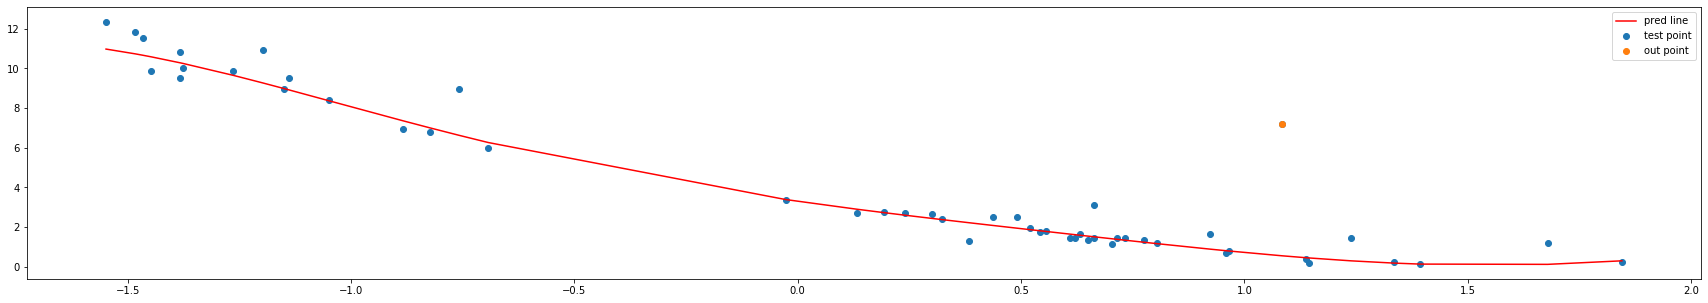

In [36]:
#fig
fig = plt.figure(figsize=(30,5))

#y_pred line
plt.plot(test_point['T10'],test_point['y_pred'],label='pred line',color='red')

#test point
plt.scatter(test_point['T10'],test_point[y_name],label='test point')

#out point
plt.scatter(out_point['T10'],out_point[y_name],label='out point')

plt.legend()
plt.show()

# del_out_point_scores:

In [37]:
print('del_out_point_scores:')
metric(test_point.loc[test_point['out'] == False ,y_name],test_point.loc[test_point['out'] == False ,'y_pred'])

del_out_point_scores:


,R2,RMSE,mean_absolute_error
C5NP,0.971261,0.66407,0.417782
